# Logistic Regression

Personal Loan Acceptance. Universal Bank is a relatively
young bank growing rapidly in terms of overall customer
acquisition.  The bank wants to explore ways of converting its
liability customers to personal loan customers.

A campaign the bank ran for liability customers last year showed
a healthy conversion rate of over 9% successes. This has
encouraged the retail marketing department to devise smarter
campaigns with better target marketing. The goal of our analysis is to model the previous campaign’s customer behavior to analyze
what combination of factors make a customer more likely to
accept a personal loan. This will serve as the basis for the design of a new campaign.

The file UniversalBank.csv contains data on 5000 customers. The
data include customer demographic information (e.g., age,
income), the customer’s relationship with the bank (e.g.,
mortgage, securities account), and the customer response to the
last personal loan campaign (Personal Loan). Among these 5000
customers, only 480 (= 9.6%) accepted the personal loan that was
offered to them in the previous campaign.

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score
from mord import LogisticIT
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split


## Load the `UniversalBank.csv` dataset. 

Age : Customer’s age in completed years
Experience : Number of years of professional experience
Income : Annual income of the customer ($000s)
Family Size : Family size of the customer
CCAvg : Average spending on credit cards per month ($000s)
Education : Education Level. 1: Undergrad; 2: Graduate; 3: Advanced/Professional
Mortgage:  Value of house mortgage if any ($000s)
Securities : Account Coded as 1 if customer has securities account with bank
CD : Account Coded as 1 if customer has certificate of deposit (CD) account with bank
Online Banking : Coded as 1 if customer uses Internet banking facilities
Credit Card : Coded as 1 if customer uses credit card issued by Universal Bank

The columns `ID` and `ZIP Code` are not relevant for model building and therefore removed.  Rducation is treated as categorical variable.

In [2]:
bank_df = pd.read_csv('datasets/UniversalBank.csv')
print(bank_df.head())
bank_df.drop(columns=['ID', 'ZIP Code'], inplace=True)
bank_df.columns = [c.replace(' ', '_') for c in bank_df.columns]
print(bank_df.head())

# treat education as categorical, convert to dummy variables
bank_df['Education'] = bank_df['Education'].astype('category')
new_categories = {1: 'Undergrad', 2: 'Graduate', 3: 'Advanced/Professional'}
bank_df.Education.cat.rename_categories(new_categories, inplace=True)
bank_df = pd.get_dummies(bank_df, prefix_sep='_', drop_first=True)

y = bank_df['Personal_Loan']
X = bank_df.drop(columns=['Personal_Loan'])

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
# Akaike information criterion (AIC) (Akaike, 1974) is a fined technique based on in-sample 
# fit to estimate the likelihood of a model to predict/estimate the future values.
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

   ID  Age  Experience  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
0   1   25           1      49     91107       4    1.6          1         0   
1   2   45          19      34     90089       3    1.5          1         0   
2   3   39          15      11     94720       1    1.0          1         0   
3   4   35           9     100     94112       1    2.7          2         0   
4   5   35           8      45     91330       4    1.0          2         0   

   Personal Loan  Securities Account  CD Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0  
2              0                   0           0       0           0  
3              0                   0           0       0           0  
4              0                   0           0       0           1  
   Age  Experience  Income  Family  CCAvg  Education  Mortgage  Personal_Loan  \
0   25      

In [3]:
predictors = ['Income']
outcome = 'Personal_Loan'

y = bank_df[outcome]
X = bank_df[predictors]

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coefficient': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -6.048919279034497
               Income
coefficient  0.036343

AIC 843.5163143186965


## Predict to get the probabilities

In [4]:
logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual': valid_y, 
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

# display four different cases
interestingCases = [2764, 932, 2721, 702]
print(logit_result.loc[interestingCases])

      actual      p(0)      p(1)  predicted
2764       0  0.952399  0.047601          0
932        0  0.878526  0.121474          0
2721       1  0.440692  0.559308          1
702        1  0.889689  0.110311          0


## Classification

In [5]:
classificationSummary(train_y, logit_reg.predict(train_X))
classificationSummary(valid_y, logit_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.9080)

       Prediction
Actual    0    1
     0 2632   81
     1  195   92
Confusion Matrix (Accuracy 0.9110)

       Prediction
Actual    0    1
     0 1763   44
     1  134   59


## Lift

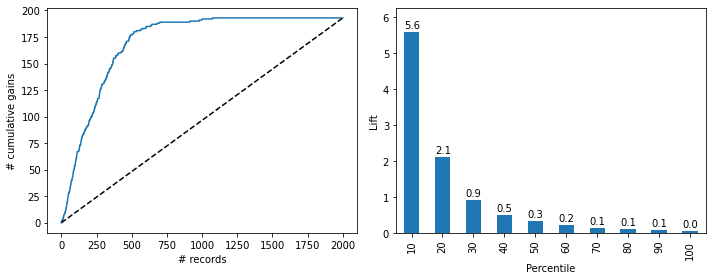

In [6]:
df = logit_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(df.actual, ax=axes[0])
liftChart(df['p(1)'], title=False, ax=axes[1])
plt.tight_layout()
plt.show()

## Cumulative Gains Chart
First, we order all the observations according to the output of the model. On the left-hand side of the horizontal axis, we place the observations with the highest probability to be target according to the model and vice versa for the right-hand side. 

In our case, at 500 records point of the horizontal axis, the 175 observations with the highest probability are located. On the vertical axis, the curve indicates which number  of all targets is included in this curve.

## Dataset Flight Delays

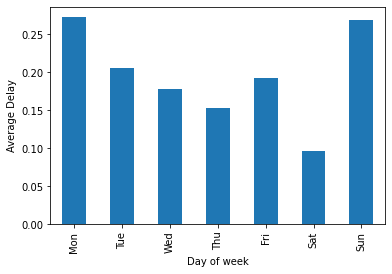

In [7]:
delays_df = pd.read_csv('datasets/FlightDelays.csv')
# Create an indicator variable
delays_df['isDelayed'] = [1 if status == 'delayed' else 0 
                          for status in delays_df['Flight Status']]

# group information by day of week and determine the average delay
averageDelay = delays_df.groupby(['DAY_WEEK'])['isDelayed'].mean()

# create a bar chart
ax = averageDelay.plot.bar(color='C0')
ax.set_xlabel('Day of week')
ax.set_ylabel('Average Delay')
_ = ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

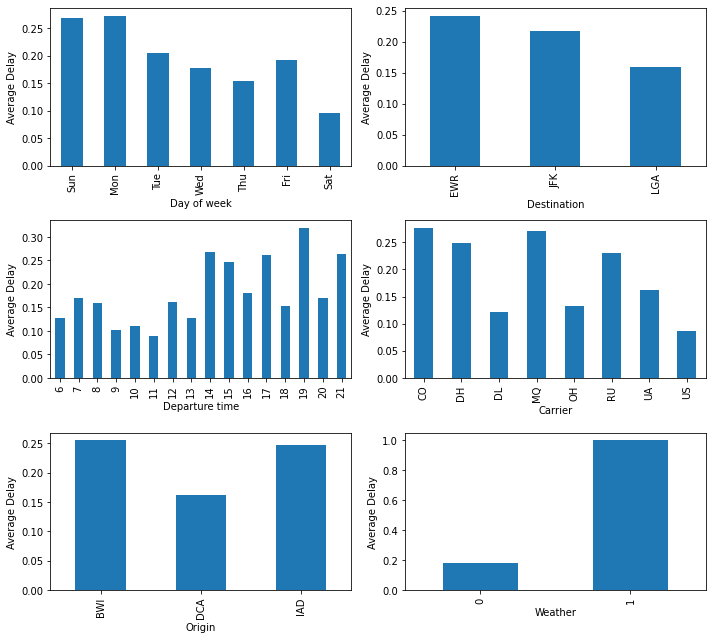

In [8]:
delays_df = pd.read_csv('datasets/FlightDelays.csv')
# Create an indicator variable
delays_df['isDelayed'] = [1 if status == 'delayed' else 0 
                          for status in delays_df['Flight Status']]

def createGraph(group, xlabel, axis):
    groupAverage = delays_df.groupby([group])['isDelayed'].mean()
    if group == 'DAY_WEEK': # rotate so that display starts on Sunday
        groupAverage = groupAverage.reindex(index=np.roll(groupAverage.index,1))
        groupAverage.index = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
    ax = groupAverage.plot.bar(color='C0', ax=axis)
    ax.set_ylabel('Average Delay')
    ax.set_xlabel(xlabel)
    return ax

def graphDepartureTime(xlabel, axis):
    temp_df = pd.DataFrame({'CRS_DEP_TIME': delays_df['CRS_DEP_TIME'] // 100, 
                            'isDelayed': delays_df['isDelayed']})
    groupAverage = temp_df.groupby(['CRS_DEP_TIME'])['isDelayed'].mean()
    ax = groupAverage.plot.bar(color='C0', ax=axis)
    ax.set_xlabel(xlabel); ax.set_ylabel('Average Delay')
    
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 9))

createGraph('DAY_WEEK', 'Day of week', axis=axes[0][0])
createGraph('DEST', 'Destination', axis=axes[0][1])
graphDepartureTime('Departure time', axis=axes[1][0])
createGraph('CARRIER', 'Carrier', axis=axes[1][1])
createGraph('ORIGIN', 'Origin', axis=axes[2][0])
createGraph('Weather', 'Weather', axis=axes[2][1])
plt.tight_layout()

plt.show()

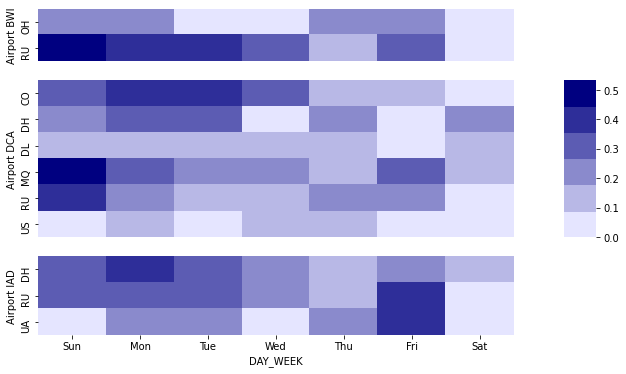

In [9]:
agg = delays_df.groupby(['ORIGIN', 'DAY_WEEK', 'CARRIER']).isDelayed.mean()
agg = agg.reset_index()

# Define the layout of the graph
height_ratios = []
for i, origin in enumerate(sorted(delays_df.ORIGIN.unique())):
    height_ratios.append(len(agg[agg.ORIGIN == origin].CARRIER.unique()))
gridspec_kw = {'height_ratios': height_ratios, 'width_ratios': [15, 1]}
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 6), 
                         gridspec_kw = gridspec_kw)
axes[0, 1].axis('off')
axes[2, 1].axis('off')

maxIsDelay = agg.isDelayed.max()
for i, origin in enumerate(sorted(delays_df.ORIGIN.unique())):
    data = pd.pivot_table(agg[agg.ORIGIN == origin], values='isDelayed', aggfunc=np.sum, 
                          index=['CARRIER'], columns=['DAY_WEEK'])
    data = data[[7, 1, 2, 3, 4, 5, 6]]  # Shift last columns to first
    ax = sns.heatmap(data, ax=axes[i][0], vmin=0, vmax=maxIsDelay, 
                     cbar_ax=axes[1][1], cmap=sns.light_palette("navy"))
    ax.set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
    if i != 2: 
        ax.get_xaxis().set_visible(False)
    ax.set_ylabel('Airport ' + origin)

plt.show()

## Table 10.7

In [10]:
delays_df = pd.read_csv('datasets/FlightDelays.csv')
# Create an indicator variable
delays_df['isDelayed'] = [1 if status == 'delayed' else 0 
                          for status in delays_df['Flight Status']]

# convert to categorical
delays_df.DAY_WEEK = delays_df.DAY_WEEK.astype('category')

# create hourly bins departure time 
delays_df.CRS_DEP_TIME = [round(t / 100) for t in delays_df.CRS_DEP_TIME]
delays_df.CRS_DEP_TIME = delays_df.CRS_DEP_TIME.astype('category')

predictors = ['DAY_WEEK', 'CRS_DEP_TIME', 'ORIGIN', 'DEST', 'CARRIER', 'Weather']
outcome = 'isDelayed'

X = pd.get_dummies(delays_df[predictors], drop_first=True)
y = delays_df[outcome]
classes = ['ontime', 'delayed']

# split into training and validation
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

logit_full = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_full.fit(train_X, train_y)

pd.set_option('display.width', 95)
pd.set_option('precision',3)
pd.set_option('max_columns', 33)
print('intercept ', logit_full.intercept_[0])

print(pd.DataFrame({'coeff': logit_full.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_full.predict(valid_X), df=len(train_X.columns) + 1))
pd.reset_option('display.width')
pd.reset_option('precision')
pd.reset_option('max_columns')

intercept  -1.2190996255195397
       Weather  DAY_WEEK_2  DAY_WEEK_3  DAY_WEEK_4  DAY_WEEK_5  DAY_WEEK_6  DAY_WEEK_7  \
coeff    9.325      -0.598      -0.705      -0.799      -0.296      -1.129      -0.135   

       CRS_DEP_TIME_7  CRS_DEP_TIME_8  CRS_DEP_TIME_9  CRS_DEP_TIME_10  CRS_DEP_TIME_11  \
coeff           0.631           0.382          -0.365            0.337            0.078   

       CRS_DEP_TIME_12  CRS_DEP_TIME_13  CRS_DEP_TIME_14  CRS_DEP_TIME_15  CRS_DEP_TIME_16  \
coeff            0.399            0.175            0.202            1.265            0.628   

       CRS_DEP_TIME_17  CRS_DEP_TIME_18  CRS_DEP_TIME_19  CRS_DEP_TIME_20  CRS_DEP_TIME_21  \
coeff            1.093            0.285            1.655            1.023            1.077   

       ORIGIN_DCA  ORIGIN_IAD  DEST_JFK  DEST_LGA  CARRIER_DH  CARRIER_DL  CARRIER_MQ  \
coeff       -0.01      -0.134    -0.524    -0.546       0.352      -0.685       0.743   

       CARRIER_OH  CARRIER_RU  CARRIER_UA  CARRI

## Figure 10.6

Confusion Matrix (Accuracy 0.8309)

        Prediction
 Actual  ontime delayed
 ontime     705       9
delayed     140      27


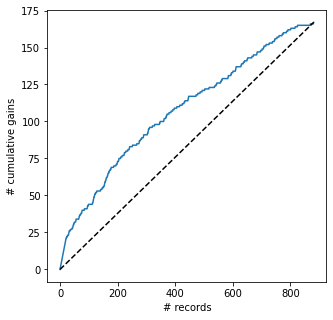

In [11]:
logit_reg_pred = logit_full.predict_proba(valid_X)
full_result = pd.DataFrame({'actual': valid_y, 
                            'p(0)': [p[0] for p in logit_reg_pred],
                            'p(1)': [p[1] for p in logit_reg_pred],
                            'predicted': logit_full.predict(valid_X)})
full_result = full_result.sort_values(by=['p(1)'], ascending=False)
# confusion matrix
classificationSummary(full_result.actual, full_result.predicted, class_names=classes)
gainsChart(full_result.actual, figsize=[5, 5])
plt.show()

## Table 10.9

In [12]:
delays_df = pd.read_csv('datasets/FlightDelays.csv')
delays_df['isDelayed'] = [1 if status == 'delayed' else 0 
                          for status in delays_df['Flight Status']]
delays_df['CRS_DEP_TIME'] = [round(t / 100) for t in delays_df['CRS_DEP_TIME']]
delays_red_df = pd.DataFrame({
    'Sun_Mon' : [1 if d in (1, 7) else 0 for d in delays_df.DAY_WEEK],
    'Weather' : delays_df.Weather,
    'CARRIER_CO_MQ_DH_RU' : [1 if d in ("CO", "MQ", "DH", "RU") else 0 
                             for d in delays_df.CARRIER],
    'MORNING' : [1 if d in (6, 7, 8, 9) else 0 for d in delays_df.CRS_DEP_TIME],
    'NOON' : [1 if d in (10, 11, 12, 13) else 0 for d in delays_df.CRS_DEP_TIME],
    'AFTER2P' : [1 if d in (14, 15, 16, 17, 18) else 0 for d in delays_df.CRS_DEP_TIME],
    'EVENING' : [1 if d in (19, 20) else 0 for d in delays_df.CRS_DEP_TIME],
    'isDelayed' : [1 if status == 'delayed' else 0 for status in delays_df['Flight Status']],
})

X = delays_red_df.drop(columns=['isDelayed'])
y = delays_red_df['isDelayed']
classes = ['ontime', 'delayed']

# split into training and validation
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, 
                                                      random_state=1)

logit_red = LogisticRegressionCV(penalty="l1", solver='liblinear', cv=5)
logit_red.fit(train_X, train_y)
pd.set_option('display.width', 100)
print('regularization', logit_red.C_)
print('intercept ', logit_red.intercept_[0])
print(pd.DataFrame({'coeff': logit_red.coef_[0]}, index=X.columns).transpose())
pd.reset_option('display.width')
print('AIC', AIC_score(valid_y, logit_red.predict(valid_X), df=len(train_X.columns) + 1))

# confusion matrix
classificationSummary(valid_y, logit_red.predict(valid_X), class_names=classes)

regularization [2.7825594]
intercept  -2.287502684193647
        Sun_Mon   Weather  CARRIER_CO_MQ_DH_RU   MORNING      NOON  AFTER2P   EVENING
coeff  0.577955  4.977979             1.298887 -0.583175 -0.665752 -0.05506  0.560989
AIC 934.6153607819033
Confusion Matrix (Accuracy 0.8343)

        Prediction
 Actual  ontime delayed
 ontime     711       3
delayed     143      24


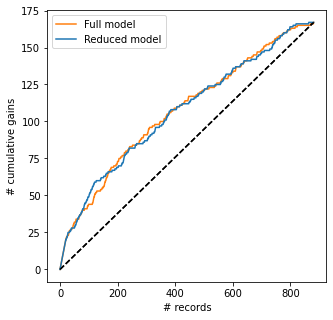

In [13]:
logit_reg_proba = logit_red.predict_proba(valid_X)
red_result = pd.DataFrame({'actual': valid_y, 
                            'p(0)': [p[0] for p in logit_reg_proba],
                            'p(1)': [p[1] for p in logit_reg_proba],
                            'predicted': logit_red.predict(valid_X),
                          })
red_result = red_result.sort_values(by=['p(1)'], ascending=False)

ax = gainsChart(full_result.actual, label='Full model', color='C1', figsize=[5, 5])
ax = gainsChart(red_result.actual, label='Reduced model', color='C0', ax=ax)
ax.legend()

plt.show()

## Table 10.9

In [14]:
# same initial preprocessing and creating dummies

# add constant column
bank_df = sm.add_constant(bank_df, prepend=True)

y = bank_df['Personal_Loan']
X = bank_df.drop(columns=['Personal_Loan'])

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# use GLM (general linear model) with the binomial family to fit a logistic regression
logit_reg = sm.GLM(train_y, train_X, family=sm.families.Binomial())
logit_result = logit_reg.fit()
print(logit_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          Personal_Loan   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2987
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -340.15
Date:                Mon, 15 Mar 2021   Deviance:                       680.30
Time:                        17:43:41   Pearson chi2:                 8.10e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [15]:
data = pd.read_csv('datasets/accidentsFull.csv')
outcome = 'MAX_SEV_IR'
predictors = ['ALCHL_I', 'WEATHER_R']

y = data[outcome]
X = data[predictors]
train_X, train_y = X, y
classes = sorted(y.unique())

print('Nominal logistic regression')
logit = LogisticRegression(penalty="l2", solver='lbfgs', C=1e24, multi_class='multinomial')
logit.fit(X, y)
print('  intercept', logit.intercept_)
print('  coefficients', logit.coef_)
print()
probs = logit.predict_proba(X)
results = pd.DataFrame({
    'actual': y, 'predicted': logit.predict(X),
    'P(0)': [p[0] for p in probs],
    'P(1)': [p[1] for p in probs],
    'P(2)': [p[2] for p in probs],
})
print(results.head())
print()


print('Ordinal logistic regression')
logit = LogisticIT(alpha=0)
logit.fit(X, y)
print('  theta', logit.theta_)
print('  coefficients', logit.coef_)
print()
probs = logit.predict_proba(X)
results = pd.DataFrame({
    'actual': y, 'predicted': logit.predict(X),
    'P(0)': [p[0] for p in probs],
    'P(1)': [p[1] for p in probs],
    'P(2)': [p[2] for p in probs],
})
print(results.head())



Nominal logistic regression
  intercept [-0.09100315  0.9036454  -0.81264225]
  coefficients [[ 0.51606685  0.3391015 ]
 [ 0.14900396  0.09543369]
 [-0.66507082 -0.43453518]]

   actual  predicted      P(0)      P(1)      P(2)
0       1          1  0.490649  0.498989  0.010362
1       0          0  0.553461  0.441147  0.005392
2       0          0  0.553461  0.441147  0.005392
3       0          1  0.490649  0.498989  0.010362
4       0          1  0.394192  0.578684  0.027124

Ordinal logistic regression
  theta [-1.06916285  2.77444326]
  coefficients [-0.40112008 -0.25174207]

   actual  predicted      P(0)      P(1)      P(2)
0       1          1  0.496205  0.482514  0.021281
1       0          0  0.558866  0.424510  0.016624
2       0          0  0.558866  0.424510  0.016624
3       0          1  0.496205  0.482514  0.021281
4       0          1  0.397402  0.571145  0.031453


## Nominal logistic regression

In [16]:
data = pd.read_csv('datasets/accidentsFull.csv')
outcome = 'MAX_SEV_IR'
predictors = ['ALCHL_I', 'WEATHER_R']
print('predictors', predictors)
print()
y = data[outcome]
X = data[predictors]
train_X, train_y = X, y
classes = sorted(y.unique())

logit = LogisticRegression(penalty="l2", solver='lbfgs', C=1e24, multi_class='multinomial')
logit.fit(X, y)

print('intercept', logit.intercept_)
print('coef', logit.coef_)
print('classes', logit.classes_)

probs = logit.predict_proba(X)
results = pd.DataFrame({
    'actual': y,
    'predicted': logit.predict(X),
    'P(a)': [p[0] for p in probs],
    'P(b)': [p[1] for p in probs],
    'P(c)': [p[2] for p in probs],
})
print(results.head())
# classificationSummary(y, results.predicted, class_names=classes)

predictors ['ALCHL_I', 'WEATHER_R']

intercept [-0.09100315  0.9036454  -0.81264225]
coef [[ 0.51606685  0.3391015 ]
 [ 0.14900396  0.09543369]
 [-0.66507082 -0.43453518]]
classes [0 1 2]
   actual  predicted      P(a)      P(b)      P(c)
0       1          1  0.490649  0.498989  0.010362
1       0          0  0.553461  0.441147  0.005392
2       0          0  0.553461  0.441147  0.005392
3       0          1  0.490649  0.498989  0.010362
4       0          1  0.394192  0.578684  0.027124


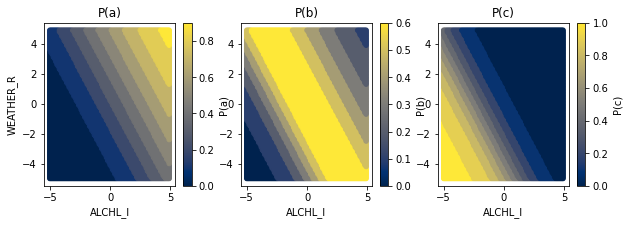

In [17]:
def plotProbabilities(model):
    n = 100
    Xtest = pd.DataFrame({
        'ALCHL_I': [(i % n) * 0.1 + (j // n) * 0.1 - 5 for i in range(n) for j in range(n)],
        'WEATHER_R': [(i // n) * 0.1 + (j % n) * 0.1 - 5 for i in range(n) for j in range(n)],
    })
    probs = logit.predict_proba(Xtest[predictors])

    results = pd.DataFrame({
        'predicted': logit.predict(Xtest[predictors]),
        'P(a)': [round(10 * p[0]) / 10 for p in probs],
        'P(b)': [round(10 * p[1]) / 10 for p in probs],
        'P(c)': [round(10 * p[2]) / 10 for p in probs],
    })
    mapped = pd.concat([results, Xtest], axis=1, sort=False)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
    for i, c in enumerate(['P(a)', 'P(b)', 'P(c)']):
        ax = mapped.plot.scatter(x='ALCHL_I', y='WEATHER_R', c=c, title=c, colormap='cividis', ax=axes[i])
        if i > 0: ax.set_ylabel('')
plotProbabilities(logit)

## Ordinal logistic regression

In [18]:
import random
from mord import LogisticIT

data = pd.read_csv('datasets/accidentsFull.csv')
outcome = 'MAX_SEV_IR'
predictors = ['ALCHL_I', 'WEATHER_R']
y = data[outcome]
X = data[predictors]
X['ALCHL_I']
train_X, train_y = X, y
classes = sorted(y.unique())

logit = LogisticIT(alpha=0)
logit.fit(X, y)

print('theta', logit.theta_)
print('coef', logit.coef_)
print('classes', logit.classes_)
print()


probs = logit.predict_proba(X)

results = pd.DataFrame({
    'actual': [yi + random.gauss(0, 0.001) for yi in y],
    'predicted': logit.predict(X),
    'P(a)': [p[0] + random.gauss(0, 0.001) for p in probs],
    'P(b)': [p[1] + random.gauss(0, 0.001) for p in probs],
    'P(c)': [p[2] + random.gauss(0, 0.001) for p in probs],
})
print(results.head())

# classificationSummary(y, results.predicted, class_names=classes)

theta [-1.06916285  2.77444326]
coef [-0.40112008 -0.25174207]
classes [0 1 2]

     actual  predicted      P(a)      P(b)      P(c)
0  0.998972          1  0.495267  0.483925  0.021574
1  0.000099          0  0.557815  0.424319  0.016902
2  0.001784          0  0.558241  0.425431  0.016020
3  0.000943          1  0.496128  0.483109  0.020651
4  0.000343          1  0.396847  0.569392  0.030879


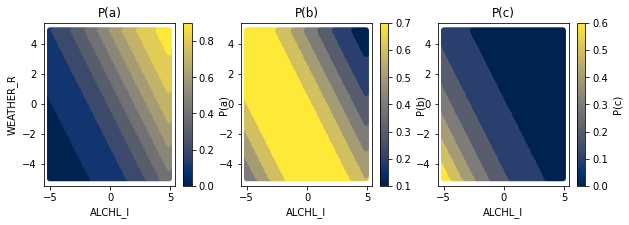

In [19]:
plotProbabilities(logit)